# Data Preprocessing and Data Analysis

#### Written by Carlos Cuevas Villarmín 

Last update: 05/08/2024

**0. Import libraries**

In [1]:
import sys, os
import pandas as pd
import numpy as np

from utils_preprocessing import *

**1. Transform Brat format into BIO.**

To do that I am going to use the following repository [https://github.com/nlplab/brat/tree/master]. In particular, the file anntoconll.py

In [2]:
#Load the brat tools
sys.path.append('brat/tools')
sys.path.append('brat/server/src')

from brat.tools.anntoconll import main

In [3]:
#Read the text roots from the data folder
txt_files = ['data/'+file for file in os.listdir('data/') if file.endswith(".txt")]
#Run the brat tools on the text files to generate the conll files
main(['-']+txt_files) #The - is a dummy argument to make the brat tools work


Eliminate Textbound(start=561, end=564, type='total-participants', text='240') due to overlap with Textbound(start=562, end=565, type='total-participants', text='240')


**2. Read the documents and create the DataFrame**

Now, once the data has been transformed into IOB format in the .conll files the following step is to read these files and create a DataFrame with the information of the files adding the File_ID the information belongs to. Additionally, to add later a column with the Sentence_ID at each file the blank lines of the files will be set to NaN to consider it as a separator.

In [4]:
data = {'File_ID': [], 'Entity': [], 'Start': [], 'End': [], 'Words': []}

#Read the root of .conll files
conll_files = sorted([file for file in os.listdir('./data/') if file.endswith(".conll")])

for file in conll_files:
    #Read the files
    file_path = os.path.join('./data/', file)
    with open(file_path, "r") as f:
        lines = f.readlines()

        #Add the info of each line of 'file' to the data dict
        for line in lines:
            data['File_ID'].append(file.split('.')[0])
            line = line.split()
            if len(line)>0:
                data['Entity'].append(line[0])
                data['Start'].append(line[1])
                data['End'].append(line[2])
                data['Words'].append(line[3])
            else: #For blank lines
                data['Entity'].append(np.nan)
                data['Start'].append(np.nan)
                data['End'].append(np.nan)
                data['Words'].append(np.nan)

#Transform data dict into DataFrame
data_df = pd.DataFrame(data)

#Report the shape and an overview of the DataFrame
print(f"Length of the data: {data_df.shape}")
data_df

Length of the data: (399068, 5)


,File_ID,Entity,Start,End,Words
0,10459028,O,0,1,A
1,10459028,O,2,12,randomized
2,10459028,O,12,13,","
3,10459028,O,14,25,prospective
4,10459028,O,26,31,study
...,...,...,...,...,...
399063,9747868,O,2769,2773,risk
399064,9747868,O,2774,2777,for
399065,9747868,O,2778,2781,the
399066,9747868,O,2782,2789,disease


Each sentence is separated by a blank line with NaN values. This structure provides the opportunity to add a sentenceID to each word, allowing us to identify all the words belonging to the same sentence.

**3. Clean the DataFrame**

**3.1. Add Sentece_ID column.** We will define a counter which will be the sentence where the word appears if label value or word value is not NaN. Otherwise, the Sentence_ID will be 0, i.e., in the cases of a blank line or sentence separator. Finally, I remove all rows with sentenceID=0 in order to not count the separators.

In [5]:
# Create list of sentences and counter
ls = []
counter = 1

for i in range(len(data_df)):
    # If the current line is not a sentence separator, we add the current counter to the list
    if ((pd.isna(data_df.Words[i]) == False) | (pd.isna(data_df.Entity[i]) == False)):
        ls.append(counter)
    # If the current line is a sentence separator, we add 0 to the list and increase the counter by 1
    if ((pd.isna(data_df.Words[i]) == True) & (pd.isna(data_df.Entity[i]) == True)):
        ls.append(0)
        counter += 1 
        
# We add the list to the dataframe        
data_df['Sentence_ID'] = ls

# Drop rows with data['Sentence_ID'] == 0 (blank lines)
data_df = data_df[data_df['Sentence_ID'] != 0]

In [6]:
print(f"Length of the data: {data_df.shape}")
#Visualize the data after adding the Sentence_ID and dropping the blank lines
data_df

Length of the data: (387101, 6)


,File_ID,Entity,Start,End,Words,Sentence_ID
0,10459028,O,0,1,A,1
1,10459028,O,2,12,randomized,1
2,10459028,O,12,13,",",1
3,10459028,O,14,25,prospective,1
4,10459028,O,26,31,study,1
...,...,...,...,...,...,...
399063,9747868,O,2769,2773,risk,11968
399064,9747868,O,2774,2777,for,11968
399065,9747868,O,2778,2781,the,11968
399066,9747868,O,2782,2789,disease,11968


**3.2. Confirm NaN values.** Confirm that now there are not NaN values in the DataFrame.

In [7]:
#Confirm if there still exist any NaN values
data_df.isnull().sum()

File_ID        0
Entity         0
Start          0
End            0
Words          0
Sentence_ID    0
dtype: int64

**3.3. Change data types of the columns.** Change the columns to its correspondent type.

In [8]:
#Confirm the type of each column
data_df.dtypes

File_ID        object
Entity         object
Start          object
End            object
Words          object
Sentence_ID     int64
dtype: object

In [9]:
#Change the type of the column 'Start' and 'End' to int
data_df['Start'] = data_df['Start'].astype(int)
data_df['End'] = data_df['End'].astype(int)

data_df.dtypes

/tmp/ipykernel_9793/1953076883.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['Start'] = data_df['Start'].astype(int)
/tmp/ipykernel_9793/1953076883.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['End'] = data_df['End'].astype(int)


File_ID        object
Entity         object
Start           int64
End             int64
Words          object
Sentence_ID     int64
dtype: object

In [10]:
#Save into csv file
data_df.to_csv('./DataProcessed/dataBIO_v3.csv', index=False)

**4. Data Analysis**

**4.1.Corpus statistics.** In this section I try to replicate the results obtained in Table 1 of the document [https://aclanthology.org/2022.wiesp-1.4.pdf] where the authors present the number of occurrences of each entity (sub-category) and the number of abstracts in which each entity is found.

In [11]:
#Create a copy of the dataframe
data2_df = data_df.copy()

#Drop the rows where the Entity is O because it is not an entity of interest
data2_df = data2_df[data2_df['Entity'] != 'O']

#Count values of the column 'Entity' that start with 'B-' because it determines the number of elements per entity
Freq = pd.DataFrame(data2_df['Entity'].value_counts())
#Drop the rows where the index starts with 'I-'
Freq = Freq[Freq.index.str.startswith('I-') == False]
Freq

#Add the number of fileID uniques where each label appears
Freq['n_files'] = data2_df.groupby('Entity')['File_ID'].nunique()

#Re-order the labels to be in the same order as in the paper mentioned
Freq = Freq.reindex(['B-total-participants', 'B-intervention-participants','B-control-participants', 'B-age', 'B-eligibility', 'B-ethinicity', 'B-condition', 'B-location', 'B-intervention', 'B-control', 'B-outcome', 'B-outcome-Measure', 'B-iv-bin-abs', 'B-cv-bin-abs', 'B-iv-bin-percent', 'B-cv-bin-percent', 'B-iv-cont-mean', 'B-cv-cont-mean', 'B-iv-cont-median', 'B-cv-cont-median', 'B-iv-cont-sd', 'B-cv-cont-sd', 'B-iv-cont-q1', 'B-cv-cont-q1', 'B-iv-cont-q3', 'B-cv-cont-q3'])

#Sum the values of the column 'count'
print(f'Total number of entities: {Freq["count"].sum()}') #Article: 17739

Freq

Total number of entities: 17719


,count,n_files
Entity,,
B-total-participants,1093,847
B-intervention-participants,887,674
B-control-participants,784,647
B-age,231,210
B-eligibility,925,864
B-ethinicity,101,83
B-condition,327,321
B-location,186,168
B-intervention,1067,1011


There exist a mismatch between the frequencies obtained and the ones reported in the paper. For example, in the case of outcome we count the entity 5038 times while in the authors original report the value 5053. I will analyze in depth what is happening to clarify the methodology followed by the authors given the lack of information. First of all, we verify that the number of files in which each entity appears is indeed correct and that there are no files where, upon reading them to transform to CoNLL format, entities have not been transcribed correctly.


In [12]:
#Prepare the labels
list_B_labels = ['B-total-participants', 'B-intervention-participants','B-control-participants', 'B-age', 'B-eligibility', 'B-ethinicity', 'B-condition', 'B-location', 'B-intervention', 'B-control', 'B-outcome', 'B-outcome-Measure', 'B-iv-bin-abs', 'B-cv-bin-abs', 'B-iv-bin-percent', 'B-cv-bin-percent', 'B-iv-cont-mean', 'B-cv-cont-mean', 'B-iv-cont-median', 'B-cv-cont-median', 'B-iv-cont-sd', 'B-cv-cont-sd', 'B-iv-cont-q1', 'B-cv-cont-q1', 'B-iv-cont-q3', 'B-cv-cont-q3']
list_I_labels = [label.replace('B-', 'I-') for label in list_B_labels]
list_ann_labels = [label.replace('B-', '') for label in list_B_labels]

I define a function to check if there is a mismatch between the number of .ann files the entity appears in and the number of File_ID where the entity is in the DataFrame.

In [13]:
freq_values = {}
files = ReadFiles('./data/')
for B_label, ann_label in zip(list_B_labels, list_ann_labels):
    print(f"\n{B_label} - {ann_label}")
    freq_values[ann_label] = CountNumberFiles(files, B_label, ann_label, data_df, Freq)


B-total-participants - total-participants
The number of files is EQUAL.
Frequency of B-total-participants in the data: 1093

B-intervention-participants - intervention-participants
The number of files is EQUAL.
Frequency of B-intervention-participants in the data: 887

B-control-participants - control-participants
The number of files is EQUAL.
Frequency of B-control-participants in the data: 784

B-age - age
The number of files is EQUAL.
Frequency of B-age in the data: 231

B-eligibility - eligibility
The number of files is EQUAL.
Frequency of B-eligibility in the data: 925

B-ethinicity - ethinicity
The number of files is EQUAL.
Frequency of B-ethinicity in the data: 101

B-condition - condition
The number of files is EQUAL.
Frequency of B-condition in the data: 327

B-location - location
The number of files is EQUAL.
Frequency of B-location in the data: 186

B-intervention - intervention
The number of files is EQUAL.
Frequency of B-intervention in the data: 1067

B-control - control

We can conclude that the number of files each entity appears in is well reproduced. The problem is not due to not having identified entities in any file and is due to having partially identified the entities in some of the files. Let's see exactly what happens in these cases. Now I add to the dictionary the authors frequency reported and create a DataFrame with all the information.

In [14]:
#Values of the paper
tag_count_paper = [1094, 887, 784, 231, 925, 101, 327, 186, 1067, 979, 5053, 1081, 556, 465, 1376, 1148, 366, 327, 270, 247, 129, 124, 4, 4, 4, 4]
n_abstracts_paper = [847, 674, 647, 210, 864, 83, 321, 168, 1011, 949, 978, 413, 288, 258, 561, 520, 154, 154, 140, 133, 69, 67, 3, 3, 3, 3]

#Add the values of the paper to the dictionary freq_values
for i, label in enumerate(list_ann_labels):
    freq_values[label]['count_paper'] = tag_count_paper[i]
    freq_values[label]['n_abstracts_paper'] = n_abstracts_paper[i]

#Define a dataframe with the values of the dictionary freq_values
df_freq_values = pd.DataFrame(freq_values).T

#Compute the difference columns
df_freq_values['diff_count'] = df_freq_values['count'] - df_freq_values['count_paper']
df_freq_values = df_freq_values[['count', 'count_paper', 'diff_count']]
df_freq_values

df_freq_values.loc[df_freq_values['diff_count'] != 0]

,count,count_paper,diff_count
total-participants,1093,1094,-1
outcome,5038,5053,-15
outcome-Measure,1077,1081,-4


Why having the correct number of files identified there are cases where the entity is partially recognize in the transformation? I create a function to identify the files where the entity is absolutely bad transform into IOB (not identified in the .ann file which is not the case) and the files where the entity is partially bad transcribed. MismatchAnalysis mode = 'inside' because the problem is inside files where the entity was recognize at least once.

In [15]:
#Get the index of the rows of interest
index_rows = df_freq_values.loc[df_freq_values['diff_count'] != 0].index #Entity names
#Transform into B-labels and I-labels format
list_B_labels = ['B-' + label for label in index_rows]
list_I_labels = [label.replace('B-', 'I-') for label in list_B_labels]

mismatch_dict = {}
for B_label, I_label, ann_label in zip(list_B_labels, list_I_labels, index_rows):
    print('------------------------------------------------------------------------------------------')
    print(f"{B_label} - {I_label} - {ann_label}")
    print('------------------------------------------------------------------------------------------')
    mismatch_dict[ann_label] = MismatchAnalysis(files, B_label, I_label, ann_label, data_df, freq_values[ann_label], folder_path = './data/', mode = 'inside', feedback = False)

------------------------------------------------------------------------------------------
B-total-participants - I-total-participants - total-participants
------------------------------------------------------------------------------------------
Number of fileIds where total-participants is not identified: 0
Mismatched amount of entities: 0
Number of files where the occurrence in .ann files and the ocurrence in the data is not the same: 1
Mismatch between the number of times B-total-participants appears in the data and the number of times total-participants appears in the .ann files: 1
Total entities badly transcribed: 1
------------------------------------------------------------------------------------------
B-outcome - I-outcome - outcome
------------------------------------------------------------------------------------------
Number of fileIds where outcome is not identified: 0
Mismatched amount of entities: 0
Number of files where the occurrence in .ann files and the ocurrence i

In the entity **total-participants**, the difference is produced by a repetition of the same text in the .ann file. Looking to the original dataset, it can be seen that '240' is labeled two times in file *15023242.ann*. While the authors did not consider these error, they count it twice and the BRAT tool as can be seen has removed one of them due to overlapping. See now these particular cases where some of the text tagged as outcome or outcome-Measure are not identified.

In [16]:
plotMismatchfiles(mismatch_dict, data_df, folder_path='./data/', control=False, feedback='all')


total-participants
------------------------------------------------------------------------------------------

File: 15023242 partially poorly transcribed in terms of the entity
T1	intervention 0 10	Paclitaxel
T2	total-participants 562 565	240
T4	control-participants 673 676	178
T5	eligibility 566 606	patients treated in 6 consecutive trials
T6	intervention-participants 826 828	62
T8	cv-cont-median 1063 1073	148 months
T9	iv-cont-median 1112 1121	45 months
T10	outcome 1156 1198	Estrogen receptor (ER) status was negative
T11	cv-bin-abs 1202 1204	58
T12	cv-bin-percent 1212 1215	33%
T13	iv-bin-abs 1232 1234	40
T14	iv-bin-percent 1242 1245	65%
T15	outcome 1321 1368	objective response rates (complete and partial)
T16	cv-bin-percent 1392 1395	74%
T17	iv-bin-percent 1406 1409	82%
T18	outcome 1416 1444	median overall survival (OS)
T19	outcome 1449 1480	progression-free survival (PFS)
T20	outcome 1631 1640	median OS
T21	cv-cont-median 1651 1660	32 months
T22	iv-cont-median 1671 1680	54 months


In the other two entities the difference in the values is causes by linking together two consecutive chunks tagged with the same entity. The authors consider these cases as two independent chunks and it is translated into two B-entity_name in the .conll file associated and in our implementation it will be only one B-entity_name. It makes sense to consider all one text tagged together than in two ways so the approach done can be assumed as correct.

Once the results of our DataFrame has been analyzed and proved to be correct it is time to prepare the data for the model.

**4.2. Length per sentence and per file analysis.** As the models have a max_length parameter it is important to know this parameter in our dataset. We can do two different approaches:

1. Consider each abstract as a unique entry. Therefore, it will provide more context. However, sometimes the size of the text will surpass max_length parameter of the model, for example the 512 tokens allowed by BERT-based models, and the text must be truncated arbitrarily.

2. Consider each sentence inside the text as an independent entry to the model. The disadvantage in this scenario is that the training time will be higher. On the other hand, the advantage is that the full information of the text can be considered, but the sentences are not related.

**4.2.1. Length analysis per sentence.** The length can be obtained counting the number of times each Sentence_ID appears in the DataFrame.

In [17]:
# Metrics for the length of the sentences in the data
data_df.Sentence_ID.value_counts().describe(include='all')

count    11968.000000
mean        32.344669
std         19.536112
min          2.000000
25%         18.000000
50%         28.000000
75%         42.000000
max        222.000000
Name: count, dtype: float64

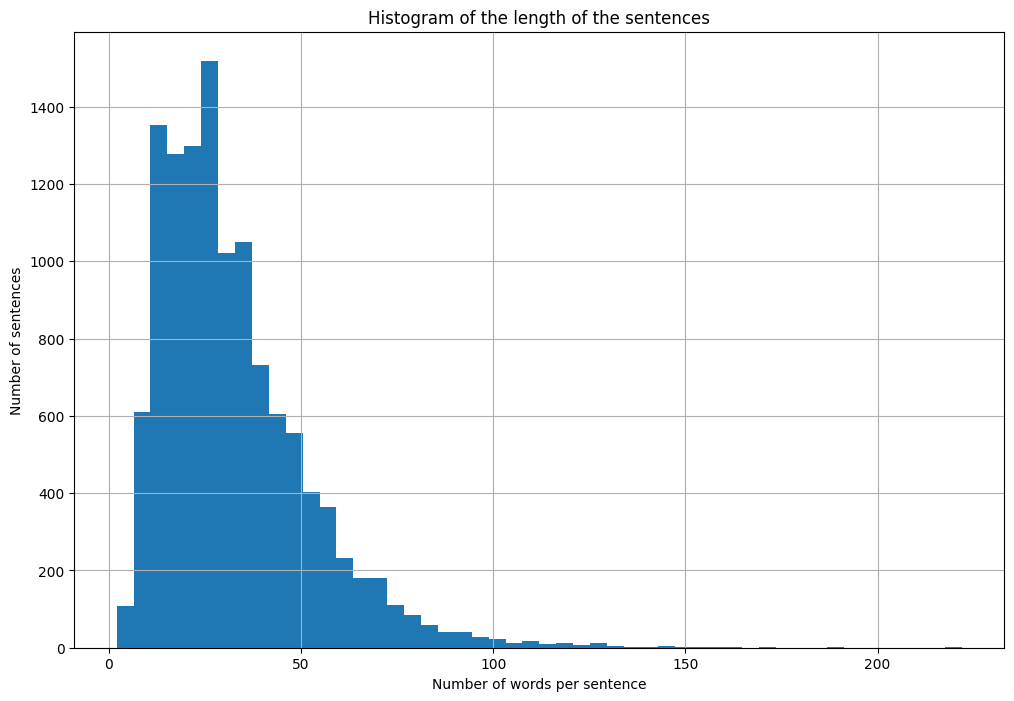

In [18]:
#Plot a histogram of the length of the sentences
import matplotlib.pyplot as plt
data_df.Sentence_ID.value_counts().hist(bins=50, figsize=(12, 8))
plt.title('Histogram of the length of the sentences')
plt.xlabel('Number of words per sentence')
plt.ylabel('Number of sentences')
plt.show()

We can see that the maximum number of words that appear in a sentence is 222 but the distribution of the sentence length has a mean around 32.

**4.2.2. Length analysis per text.** In that case the number of words per file can be obtain counting the times each File_ID appears in the DataFrame.

In [19]:
# Metrics for the length of the text in the data
data_df.File_ID.value_counts().describe(include='all')

count    1011.000000
mean      382.889219
std        93.521214
min       185.000000
25%       329.000000
50%       372.000000
75%       415.000000
max       986.000000
Name: count, dtype: float64

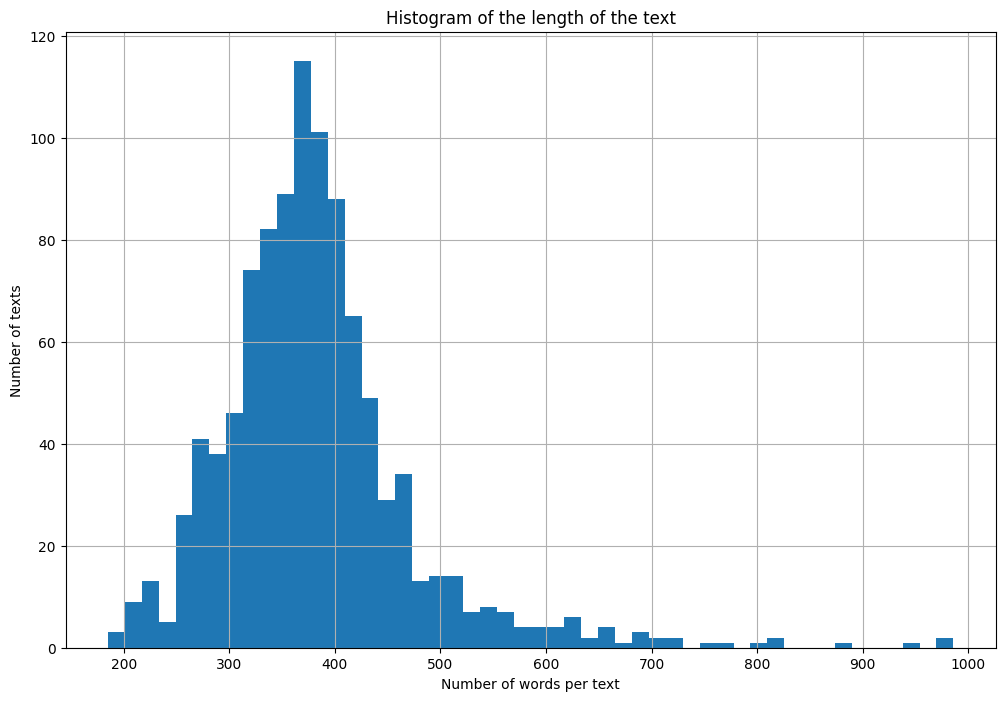

In [20]:
#Plot a histogram of the length of the sentences
import matplotlib.pyplot as plt
data_df.File_ID.value_counts().hist(bins=50, figsize=(12, 8))
plt.title('Histogram of the length of the text')
plt.xlabel('Number of words per text')
plt.ylabel('Number of texts')
plt.show()

Let see how many files hava length greater than 512.

In [21]:
print(f"The number of files with a length greater than 512 is: {sum(data_df.File_ID.value_counts() > 512)}")

The number of files with a length greater than 512 is: 74


These files should be split into two different files to be able to use the full text as input of the model. In case of using this approach the modification will be done after using the particular tokenizer of the model chosen. LongFormer model does not present any problem because works with a higher max_length value. When training BioBERT with the full texts the cases where the length is greater than 512 will be truncated to this size and information will be lost.

**5. Split into train/validation/test set**

To do that, we will extract from the list of File_ID 80% randomly to be the files of the train set and 10% for validation and test sets. Then, we will save the dataframes as dataBIO_train.csv, dataBIO_val.csv and dataBIO_test.csv. Additionally, we will create a default dataset without splitting to have the capacity to manipulate it later if necessary.

**Remark:** The authors report in the paper that they split randomly into 80%-20% for train and test set without talking about validation set so the split will cause a difference between the dataset created for training and the one created by the authors.

In [22]:
#Create a list of the fileID uniques
File_ID = data_df['File_ID'].unique()
File_ID

array(['10459028', '10547391', '11136837', ..., '9672274', '9678620',
       '9747868'], dtype=object)

In [23]:
# Create a new random generator
rng = np.random.default_rng(20)

# Convert File_ID to a numpy array
File_ID_np = np.array(File_ID)

# Generate indices for training set
train_indices = rng.choice(len(File_ID_np), size=int(len(File_ID_np)*0.8), replace=False)

# Get the training set
train = File_ID_np[train_indices]

# Get the remaining indices
remaining_indices = np.array([i for i in File_ID_np if i not in train])

# Assuming `train` is a numpy array containing the elements you want to compare with `File_ID_np`
not_in_train = np.setdiff1d(File_ID_np, train)                 #For Experiment 1 split train-test

#For Experiment 2 split train-valid-test
# Generate indices for validation set from the remaining indices
rng = np.random.default_rng(20)
valid_indices = rng.choice(len(remaining_indices), size=int(len(remaining_indices)*0.5), replace=False)
# Get the validation set
valid = remaining_indices[valid_indices]

# Get the test set
test = np.array(np.setdiff1d(remaining_indices, valid))

In [24]:
#Generate the dataBIO dataframes for each set
train_df = data_df[data_df['File_ID'].isin(list(train))]
valid_df = data_df[data_df['File_ID'].isin(list(valid))]
test_df = data_df[data_df['File_ID'].isin(list(test))]
not_in_train_df = data_df[data_df['File_ID'].isin(list(not_in_train))]

#Comprobation of the length of the dataframes
train_df['File_ID'].nunique(), valid_df['File_ID'].nunique(), test_df['File_ID'].nunique()

(808, 101, 102)

**6. Analysis of the sets**

Now, we can compute how many elements each entity has in each of the sets. Firstly, we will compute how many times each B_ner_Tag appears in order to know how many sets of tokens have been tagged per set.

In [25]:
Freq['train_set'] = train_df[train_df['Entity'] != 'O'].value_counts('Entity')
Freq['valid_set'] = valid_df[valid_df['Entity'] != 'O'].value_counts('Entity')
Freq['test_set'] = test_df[test_df['Entity'] != 'O'].value_counts('Entity')
Freq['not_in_train'] = not_in_train_df[not_in_train_df['Entity'] != 'O'].value_counts('Entity')

#Freq.to_csv("Freq_B_tags.csv")
Freq

,count,n_files,train_set,valid_set,test_set,not_in_train
Entity,,,,,,
B-total-participants,1093,847,870,105,118.0,223
B-intervention-participants,887,674,702,91,94.0,185
B-control-participants,784,647,616,82,86.0,168
B-age,231,210,184,20,27.0,47
B-eligibility,925,864,737,90,98.0,188
B-ethinicity,101,83,85,10,6.0,16
B-condition,327,321,277,24,26.0,50
B-location,186,168,143,23,20.0,43
B-intervention,1067,1011,853,104,110.0,214


We will compute the frequency of the entity without making the distinction of the prefix to know the number of words belongs to each entity. Notice that the support reported by seqeval will be the amount of B-ner_tags when computing the evaluation metrics.

In [26]:
#Count the number of entities in each set
counter_train = train_df['Entity'].apply(lambda x: ' '.join([word.split('-',1)[1] if word != 'O' else word for word in x.split()])).value_counts()
counter_valid = valid_df['Entity'].apply(lambda x: ' '.join([word.split('-',1)[1] if word != 'O' else word for word in x.split()])).value_counts()
counter_test = test_df['Entity'].apply(lambda x: ' '.join([word.split('-',1)[1] if word != 'O' else word for word in x.split()])).value_counts()
counter_not_in_train = not_in_train_df['Entity'].apply(lambda x: ' '.join([word.split('-',1)[1] if word != 'O' else word for word in x.split()])).value_counts()
#Count the number of entities in all the data
counter_all = data_df['Entity'].apply(lambda x: ' '.join([word.split('-',1)[1] if word != 'O' else word for word in x.split()])).value_counts()

#Create a dataframe with the values of the counters
df_counter = pd.DataFrame({'all': counter_all, 'train': counter_train, 'valid': counter_valid, 'test': counter_test, 'not_in_train': counter_not_in_train})

#Reindex the dataframe
df_counter = df_counter.reindex(['total-participants', 'intervention-participants', 'control-participants', 'age', 'eligibility', 'ethinicity', 'condition', 'location', 'intervention', 'control', 'outcome', 'outcome-Measure', 'iv-bin-abs', 'cv-bin-abs', 'iv-bin-percent', 'cv-bin-percent', 'iv-cont-mean', 'cv-cont-mean', 'iv-cont-median', 'cv-cont-median', 'iv-cont-sd', 'cv-cont-sd', 'iv-cont-q1', 'cv-cont-q1', 'iv-cont-q3', 'cv-cont-q3'])

df_counter

#Save the dataframe into a csv file
#df_counter.to_csv('Freq_entities.csv')

,all,train,valid,test,not_in_train
Entity,,,,,
total-participants,1648,1304,164,180.0,344
intervention-participants,992,790,106,96.0,202
control-participants,872,697,89,86.0,175
age,1055,835,103,117.0,220
eligibility,10333,8183,1037,1113.0,2150
ethinicity,150,122,22,6.0,28
condition,1075,922,69,84.0,153
location,356,265,47,44.0,91
intervention,3642,2905,370,367.0,737


We can see that mostly in all the cases the amount of times each entity appears respect the distribution 80-10-10 of the total.

For each set I will define a dataFrame to know how many tokens are per field, how many sentences, ratios, etc.

In [27]:
train_info = GenerateInfoDF(train_df)
valid_info = GenerateInfoDF(valid_df)
test_info = GenerateInfoDF(test_df)
not_in_train_info = GenerateInfoDF(not_in_train_df)

In [28]:
#print('Train set information per file')
#train_info
print('Train set statistics')
display(train_info.describe())

#print('Validation set information per file')
#valid_info
print('Validation set statistics')
display(valid_info.describe())

#print('Test set information per file')
#test_info
print('Test set statistics')
display(test_info.describe())

#print('Not in train set information per file')
#not_in_train_info
print('Not in train set statistics')
display(not_in_train_info.describe())

Train set statistics


,n_sentences,n_tokens,n_entities,n_unique_entities,ratio_entities_sentence,ratio_entities_token
count,808.000000,808.000000,808.000000,808.000000,808.000000,808.000000
mean,12.764851,380.985149,59.695545,9.415842,4.816059,0.157709
std,2.885103,91.968408,25.105850,2.719036,2.066949,0.057399
min,6.000000,185.000000,14.000000,3.000000,0.777778,0.027290
25%,11.000000,327.000000,40.000000,7.000000,3.272727,0.115080
50%,12.000000,372.000000,57.000000,10.000000,4.535897,0.153001
75%,15.000000,414.250000,75.000000,11.000000,5.955882,0.192227
max,24.000000,986.000000,198.000000,20.000000,14.500000,0.383333


Validation set statistics


,n_sentences,n_tokens,n_entities,n_unique_entities,ratio_entities_sentence,ratio_entities_token
count,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000
mean,12.831683,390.188119,57.376238,9.435644,4.584231,0.148286
std,2.946419,97.328178,26.116222,2.620747,2.152221,0.058829
min,7.000000,205.000000,10.000000,3.000000,0.769231,0.028818
25%,11.000000,332.000000,39.000000,8.000000,3.000000,0.108374
50%,12.000000,377.000000,52.000000,10.000000,4.333333,0.147505
75%,15.000000,423.000000,70.000000,11.000000,5.500000,0.179551
max,21.000000,767.000000,148.000000,17.000000,14.000000,0.373737


Test set statistics


,n_sentences,n_tokens,n_entities,n_unique_entities,ratio_entities_sentence,ratio_entities_token
count,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000
mean,13.411765,390.745098,57.990196,9.411765,4.470326,0.149706
std,3.357725,101.768490,25.693354,2.689742,2.025322,0.056869
min,7.000000,204.000000,18.000000,4.000000,1.500000,0.046997
25%,11.000000,337.750000,40.000000,7.250000,3.085714,0.106278
50%,13.000000,365.500000,53.000000,10.000000,4.222222,0.141404
75%,15.000000,411.000000,72.750000,11.000000,5.237500,0.186970
max,26.000000,819.000000,161.000000,16.000000,11.428571,0.292162


Not in train set statistics


,n_sentences,n_tokens,n_entities,n_unique_entities,ratio_entities_sentence,ratio_entities_token
count,203.000000,203.000000,203.000000,203.000000,203.000000,203.000000
mean,13.123153,390.467980,57.684729,9.423645,4.526998,0.148999
std,3.165345,99.337721,25.842231,2.649086,2.085023,0.057713
min,7.000000,204.000000,10.000000,3.000000,0.769231,0.028818
25%,11.000000,334.000000,40.000000,7.500000,3.000000,0.107007
50%,13.000000,370.000000,52.000000,10.000000,4.230769,0.144638
75%,15.000000,417.000000,71.000000,11.000000,5.460606,0.181577
max,26.000000,819.000000,161.000000,17.000000,14.000000,0.373737


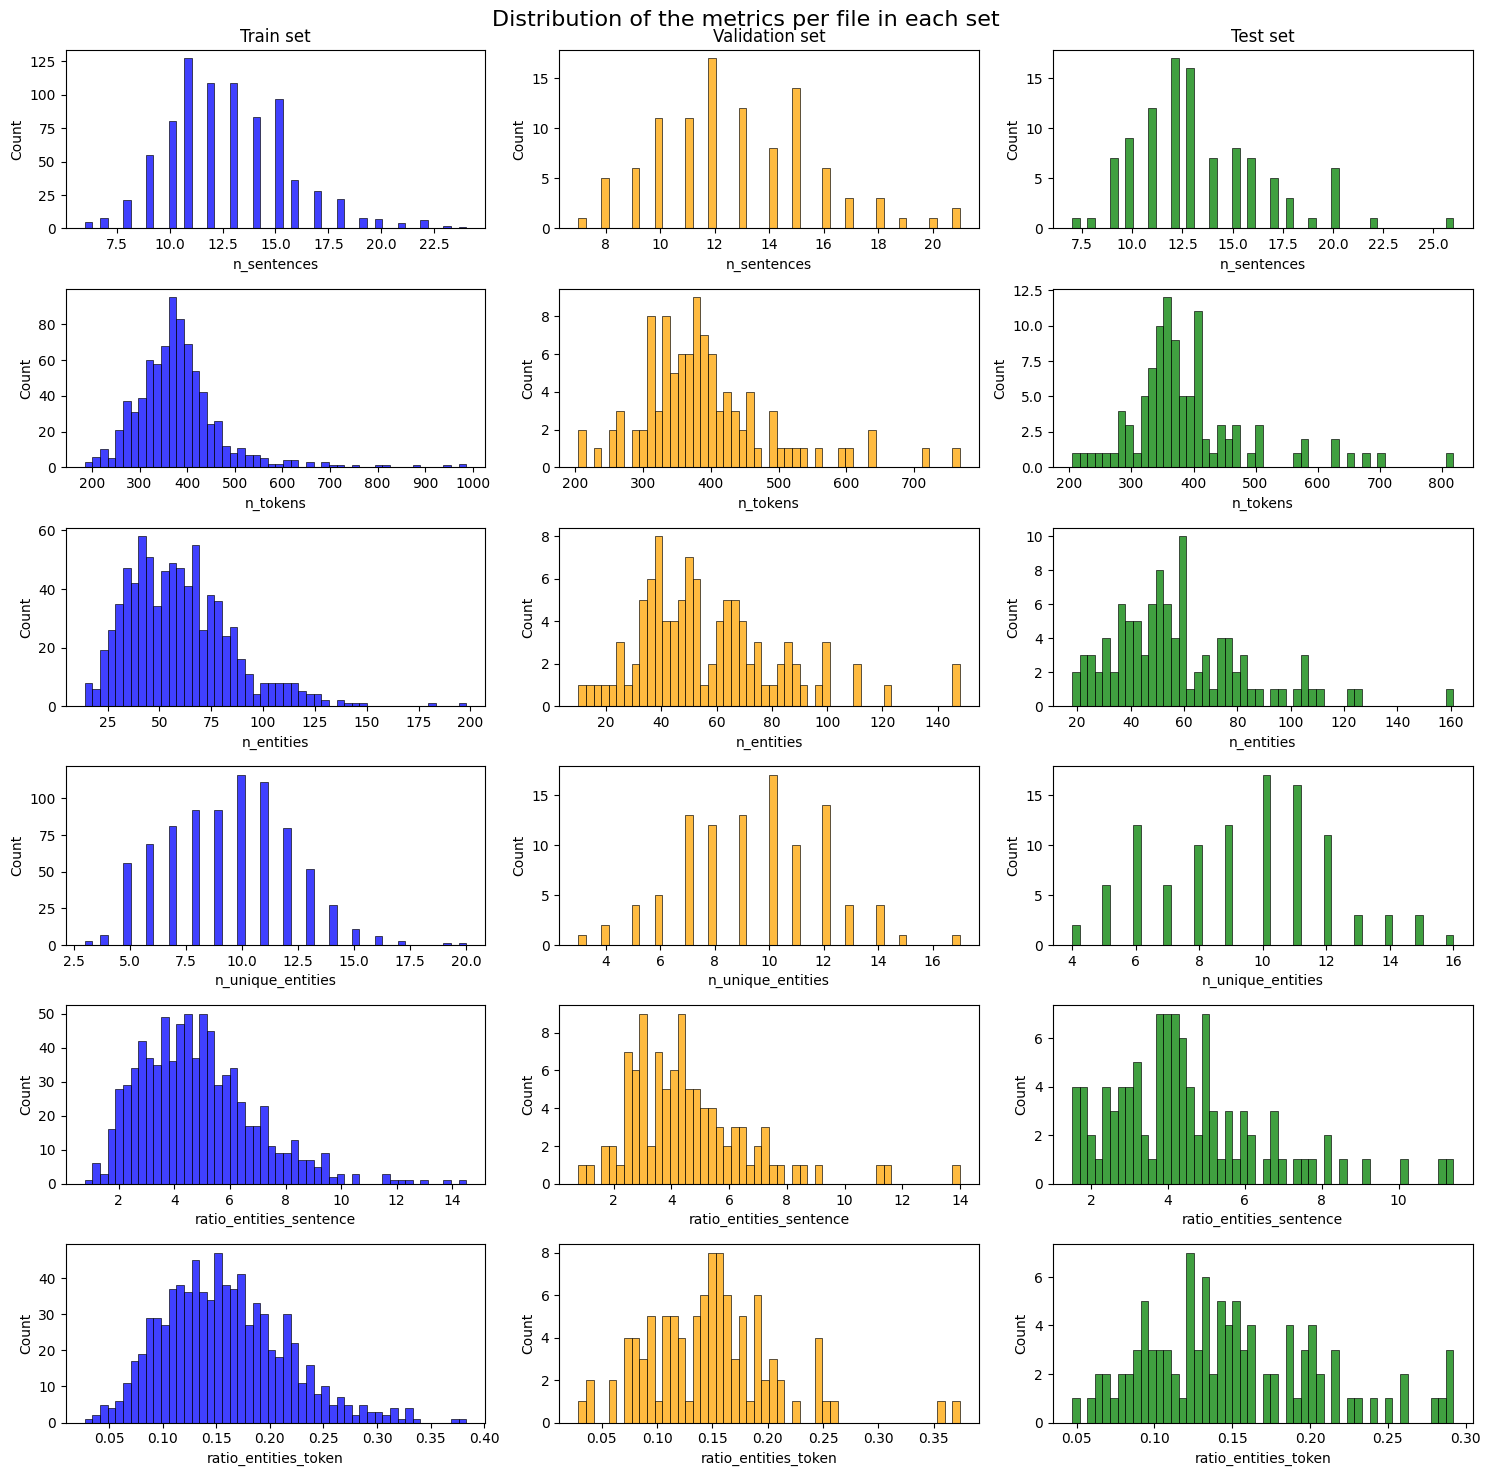

In [29]:
#Generate a plot with subfigures where each row is a column of the dataframe train_info and each column is a set (train, valid, test) and plot a histogram
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(6, 3, figsize=(15, 15))
fig.suptitle('Distribution of the metrics per file in each set', fontsize=16)

sns.histplot(ax=axes[0, 0], data=train_info, x='n_sentences', bins=50, color='blue')
axes[0, 0].set_title('Train set')
sns.histplot(ax=axes[0, 1], data=valid_info, x='n_sentences', bins=50, color='orange')
axes[0, 1].set_title('Validation set')
sns.histplot(ax=axes[0, 2], data=test_info, x='n_sentences', bins=50, color='green')
axes[0, 2].set_title('Test set')

sns.histplot(ax=axes[1, 0], data=train_info, x='n_tokens', bins=50, color='blue')   
sns.histplot(ax=axes[1, 1], data=valid_info, x='n_tokens', bins=50, color='orange')
sns.histplot(ax=axes[1, 2], data=test_info, x='n_tokens', bins=50, color='green')

sns.histplot(ax=axes[2, 0], data=train_info, x='n_entities', bins=50, color='blue')
sns.histplot(ax=axes[2, 1], data=valid_info, x='n_entities', bins=50, color='orange')
sns.histplot(ax=axes[2, 2], data=test_info, x='n_entities', bins=50, color='green')

sns.histplot(ax=axes[3, 0], data=train_info, x='n_unique_entities', bins=50, color='blue')
sns.histplot(ax=axes[3, 1], data=valid_info, x='n_unique_entities', bins=50, color='orange')
sns.histplot(ax=axes[3, 2], data=test_info, x='n_unique_entities', bins=50, color='green')

sns.histplot(ax=axes[4, 0], data=train_info, x='ratio_entities_sentence', bins=50, color='blue')
sns.histplot(ax=axes[4, 1], data=valid_info, x='ratio_entities_sentence', bins=50, color='orange')
sns.histplot(ax=axes[4, 2], data=test_info, x='ratio_entities_sentence', bins=50, color='green')

sns.histplot(ax=axes[5, 0], data=train_info, x='ratio_entities_token', bins=50, color='blue')
sns.histplot(ax=axes[5, 1], data=valid_info, x='ratio_entities_token', bins=50, color='orange')
sns.histplot(ax=axes[5, 2], data=test_info, x='ratio_entities_token', bins=50, color='green')

#Define the distance between the subplots
plt.tight_layout(pad=1.0)

plt.show()

We can conclude that the distribution of the considered metrics are similar in the validation and test set in all the cases which is important in order to analyse once the models are fine-tuned the capacity of generalization. The metrics are different to the train set results. However, this is not necessarely a problem and it will be probably caused by the considerably higher number of files in the set.

**7. Prepare data to pass it to the model**

Depending on the approach chosen the model will receive an input per text or an input per sentence of each text. We will consider the full file as input. If the user is interested in the sentence level it can be generated by `entry_param="sentence"` in the PreprocessingData function.

In [30]:
#Case of complete text
df_train_processed = PreprocessingData(train_df)
df_valid_processed = PreprocessingData(valid_df)
df_test_processed = PreprocessingData(test_df)
df_not_in_train_processed = PreprocessingData(not_in_train_df)

#Preprocess all the data together
df_processed = PreprocessingData(data_df)

/home/carlos/MASTER/ClinicalTrials/utils_preprocessing.py:282: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Sentence'] = df.groupby(['File_ID'])['Words'].transform(lambda x: ' '.join(x))
/home/carlos/MASTER/ClinicalTrials/utils_preprocessing.py:284: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Entity_sentence'] = df.groupby(['File_ID'])['Entity'].transform(lambda x: ' '.join(x))
/home/carlos/MASTER/ClinicalTrials/utils_preprocessing.py:282: SettingWithCopyWarning: 
A value is trying to be set on a

In [31]:
#Check that the number of unique rows is the same as the number of unique File_ID after preprocessing
print(f"Number of unique rows in train set: {train_df['File_ID'].nunique()}")
print(f"Number of unique rows in train set processed: {df_train_processed['File_ID'].nunique()}")
print(f"Number of unique rows in valid set: {valid_df['File_ID'].nunique()}")
print(f"Number of unique rows in valid set processed: {df_valid_processed['File_ID'].nunique()}")
print(f"Number of unique rows in test set: {test_df['File_ID'].nunique()}")
print(f"Number of unique rows in test set processed: {df_test_processed['File_ID'].nunique()}")
print(f"Number of unique rows in all the data: {data_df['File_ID'].nunique()}")
print(f"Number of unique rows in all the data processed: {df_processed['File_ID'].nunique()}")
print(f"Number of unique rows in not in train set: {not_in_train_df['File_ID'].nunique()}")
print(f"Number of unique rows in not in train set processed: {df_not_in_train_processed['File_ID'].nunique()}")

#Examples to know how the data is being processed
df_processed.head()

Number of unique rows in train set: 808
Number of unique rows in train set processed: 808
Number of unique rows in valid set: 101
Number of unique rows in valid set processed: 101
Number of unique rows in test set: 102
Number of unique rows in test set processed: 102
Number of unique rows in all the data: 1011
Number of unique rows in all the data processed: 1011
Number of unique rows in not in train set: 203
Number of unique rows in not in train set processed: 203


,File_ID,Sentence,Entity_sentence
0,10459028,"A randomized , prospective study of endometria...",O O O O O O B-intervention I-intervention O O ...
1,10547391,Randomized trial of fenretinide to prevent sec...,O O O B-intervention O O B-condition I-conditi...
2,11136837,Cardiovascular effects of tamoxifen in women w...,O O O B-intervention O O O O O O O O O O O O O...
3,11283119,Tamoxifen for the prevention of breast cancer ...,B-intervention O O O O O O O O O O O O O O O O...
4,12374678,A phase II breast cancer chemoprevention trial...,O O O O O O O O O B-intervention I-interventio...


**7. Save the BIO dataFrames for each set and train/val/test sets processed**

In [32]:
not_in_train_df.to_csv('./DataProcessed/test_and_validBIO_v1.csv', sep=' ', index=False) #Experiment 1

In [33]:
df_not_in_train_processed.to_csv('./DataProcessed/test_and_valid_v1.csv', sep = ' ', index=False) #Experiment 1

In [34]:
#Experiment 2
train_df.to_csv('./DataProcessed/trainBIO_v02.csv', sep=' ', index=False)
valid_df.to_csv('./DataProcessed/validBIO_v02.csv', sep=' ', index=False)
test_df.to_csv('./DataProcessed/testBIO_v02.csv', sep=' ', index=False)

In [35]:
#Experiment 2
df_train_processed.to_csv('./DataProcessed/train_v02.csv', sep=' ', index=False)
df_valid_processed.to_csv('./DataProcessed/valid_v02.csv', sep=' ', index=False)
df_test_processed.to_csv('./DataProcessed/test_v02.csv', sep=' ', index=False)

df_processed.to_csv('./DataProcessed/full_data.csv', sep=' ', index=False)

**8. Create the DataSet.**

In [36]:
#Load data from csv files if the notebook is restarted

path_train = "./DataProcessed/train_v02.csv"
path_valid = "./DataProcessed/valid_v02.csv"
path_test  = "./DataProcessed/test_v02.csv"
path_data  = "./DataProcessed/full_data.csv"
path_tv    = "./DataProcessed/test_and_valid_v1.csv"

import pandas as pd

def load_data(path):
    #Read csv file specifying that the first row is the header
    df = pd.read_csv(path, sep=" ", header=0)
    return df

train = load_data(path_train)
valid = load_data(path_valid)
test  = load_data(path_test)
data  = load_data(path_data)
not_in_train = load_data(path_tv)

I split the elements of each sentence (or text) and save it in a list.

In [37]:
words_train, words_labels_train = SplitData(train)
words_valid, words_labels_valid = SplitData(valid)
words_test, words_labels_test = SplitData(test)
words_tv, words_labels_tv = SplitData(not_in_train)

words_data, words_labels_data = SplitData(data)

Number of sentences:  808
Number of labels:  808
Number of sentences:  101
Number of labels:  101
Number of sentences:  102
Number of labels:  102
Number of sentences:  203
Number of labels:  203
Number of sentences:  1011
Number of labels:  1011


Map the words_labels into int values.

In [38]:
#Define the tags
tag_values =["O",
            "B-total-participants",
            "I-total-participants",
            "B-intervention-participants",
            "I-intervention-participants",
            "B-control-participants",
            "I-control-participants",
            "B-age",
            "I-age",
            "B-eligibility",
            "I-eligibility",
            "B-ethinicity",
            "I-ethinicity",
            "B-condition",
            "I-condition",
            "B-location",
            "I-location",
            "B-intervention",
            "I-intervention",
            "B-control",
            "I-control",
            "B-outcome",
            "I-outcome",
            "B-outcome-Measure",
            "I-outcome-Measure",
            "B-iv-bin-abs",
            "I-iv-bin-abs",
            "B-cv-bin-abs",
            "I-cv-bin-abs",
            "B-iv-bin-percent",
            "I-iv-bin-percent",
            "B-cv-bin-percent",
            "I-cv-bin-percent",
            "B-iv-cont-mean",
            "I-iv-cont-mean",
            "B-cv-cont-mean",
            "I-cv-cont-mean",
            "B-iv-cont-median",
            "I-iv-cont-median",
            "B-cv-cont-median",
            "I-cv-cont-median",
            "B-iv-cont-sd",
            "I-iv-cont-sd",
            "B-cv-cont-sd",
            "I-cv-cont-sd",
            "B-iv-cont-q1",
            "I-iv-cont-q1",
            "B-cv-cont-q1",
            "I-cv-cont-q1",
            "B-iv-cont-q3",
            "I-iv-cont-q3",
            "B-cv-cont-q3",
            "I-cv-cont-q3"]

tag2idx = {t: i for i, t in enumerate(tag_values)}
idx2tag = {i: t for i, t in enumerate(tag_values)}

print(tag2idx)
print(idx2tag)

{'O': 0, 'B-total-participants': 1, 'I-total-participants': 2, 'B-intervention-participants': 3, 'I-intervention-participants': 4, 'B-control-participants': 5, 'I-control-participants': 6, 'B-age': 7, 'I-age': 8, 'B-eligibility': 9, 'I-eligibility': 10, 'B-ethinicity': 11, 'I-ethinicity': 12, 'B-condition': 13, 'I-condition': 14, 'B-location': 15, 'I-location': 16, 'B-intervention': 17, 'I-intervention': 18, 'B-control': 19, 'I-control': 20, 'B-outcome': 21, 'I-outcome': 22, 'B-outcome-Measure': 23, 'I-outcome-Measure': 24, 'B-iv-bin-abs': 25, 'I-iv-bin-abs': 26, 'B-cv-bin-abs': 27, 'I-cv-bin-abs': 28, 'B-iv-bin-percent': 29, 'I-iv-bin-percent': 30, 'B-cv-bin-percent': 31, 'I-cv-bin-percent': 32, 'B-iv-cont-mean': 33, 'I-iv-cont-mean': 34, 'B-cv-cont-mean': 35, 'I-cv-cont-mean': 36, 'B-iv-cont-median': 37, 'I-iv-cont-median': 38, 'B-cv-cont-median': 39, 'I-cv-cont-median': 40, 'B-iv-cont-sd': 41, 'I-iv-cont-sd': 42, 'B-cv-cont-sd': 43, 'I-cv-cont-sd': 44, 'B-iv-cont-q1': 45, 'I-iv-cont

In [39]:
#Map the labels to the tags
labels_train = MapLabels(words_labels_train, tag2idx)
labels_valid = MapLabels(words_labels_valid, tag2idx)
labels_test  = MapLabels(words_labels_test, tag2idx)
labels_tv    = MapLabels(words_labels_tv, tag2idx)

labels_data  = MapLabels(words_labels_data, tag2idx)

In [40]:
#Create a dataset for each set
train_dataset = CreateDataset(words_train, labels_train, tag_values, list(train['File_ID']))
valid_dataset = CreateDataset(words_valid, labels_valid, tag_values, list(valid['File_ID']))
test_dataset  = CreateDataset(words_test, labels_test, tag_values, list(test['File_ID']))
tv_dataset    = CreateDataset(words_tv, labels_tv, tag_values, list(not_in_train['File_ID']))

data_dataset  = CreateDataset(words_data, labels_data, tag_values, list(data['File_ID']))

train_dataset.features


{'id': Value(dtype='string', id=None),
 'tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'ner_tags': Sequence(feature=ClassLabel(names=['O', 'B-total-participants', 'I-total-participants', 'B-intervention-participants', 'I-intervention-participants', 'B-control-participants', 'I-control-participants', 'B-age', 'I-age', 'B-eligibility', 'I-eligibility', 'B-ethinicity', 'I-ethinicity', 'B-condition', 'I-condition', 'B-location', 'I-location', 'B-intervention', 'I-intervention', 'B-control', 'I-control', 'B-outcome', 'I-outcome', 'B-outcome-Measure', 'I-outcome-Measure', 'B-iv-bin-abs', 'I-iv-bin-abs', 'B-cv-bin-abs', 'I-cv-bin-abs', 'B-iv-bin-percent', 'I-iv-bin-percent', 'B-cv-bin-percent', 'I-cv-bin-percent', 'B-iv-cont-mean', 'I-iv-cont-mean', 'B-cv-cont-mean', 'I-cv-cont-mean', 'B-iv-cont-median', 'I-iv-cont-median', 'B-cv-cont-median', 'I-cv-cont-median', 'B-iv-cont-sd', 'I-iv-cont-sd', 'B-cv-cont-sd', 'I-cv-cont-sd', 'B-iv-cont-q1', 'I-iv-cont-q1', '

In [41]:
#Transform dataset dict into a dataset object
from datasets import DatasetDict

dataset = DatasetDict({"train": train_dataset, "valid": valid_dataset, "test": test_dataset})
dataset2 = DatasetDict({"train": train_dataset, "test": tv_dataset})

#Dataset with default split
print("Experiment 1")
display(dataset2)
print("Experiment 2")
display(dataset)
#Dataset without split
display(data_dataset)

Experiment 1


DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 808
    })
    test: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 203
    })
})

Experiment 2


DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 808
    })
    valid: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 101
    })
    test: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 102
    })
})

Dataset({
    features: ['id', 'tokens', 'ner_tags'],
    num_rows: 1011
})

In [42]:
#Save the dataset
dataset.save_to_disk("./DataProcessed/dataset_split_v0.2")
dataset2.save_to_disk('./DataProcessed/train_test_split_v0.2')
data_dataset.save_to_disk("./DataProcessed/dataset_v0.2")

Saving the dataset (0/1 shards):   0%|          | 0/808 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/101 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/102 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/808 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/203 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1011 [00:00<?, ? examples/s]

**9. Push the Dataset to HuggingFace.**

In [43]:
#huggingface-cli login (in terminal)
from huggingface_hub import notebook_login
notebook_login()
dataset2.push_to_hub("cuevascarlos/PICO-breast-cancer", config_name="train_test_split-v2", commit_message="Data splitted into train (80%) and test set (20%)")
dataset.push_to_hub("cuevascarlos/PICO-breast-cancer", config_name="Default_split-v2", commit_message="Data splitted into train (80%), validation (10%) and test set (10%)")
data_dataset.push_to_hub("cuevascarlos/PICO-breast-cancer", config_name="Data-v2", commit_message="Full dataset")

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

README.md:   0%|          | 0.00/7.54k [00:00<?, ?B/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

README.md:   0%|          | 0.00/9.66k [00:00<?, ?B/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

README.md:   0%|          | 0.00/11.9k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/datasets/cuevascarlos/PICO-breast-cancer/commit/3faf6ac6f6c98b763e82307b3e450712b0e1bf8e', commit_message='Full dataset', commit_description='', oid='3faf6ac6f6c98b763e82307b3e450712b0e1bf8e', pr_url=None, pr_revision=None, pr_num=None)